In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import odhpy
import odhpy.io as oio
import odhpy.plots as opl
import odhpy.utils as out

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)

print("ODHpy version: ", odhpy.__version__)

ODHpy version:  0.2.3


(20, 20000)

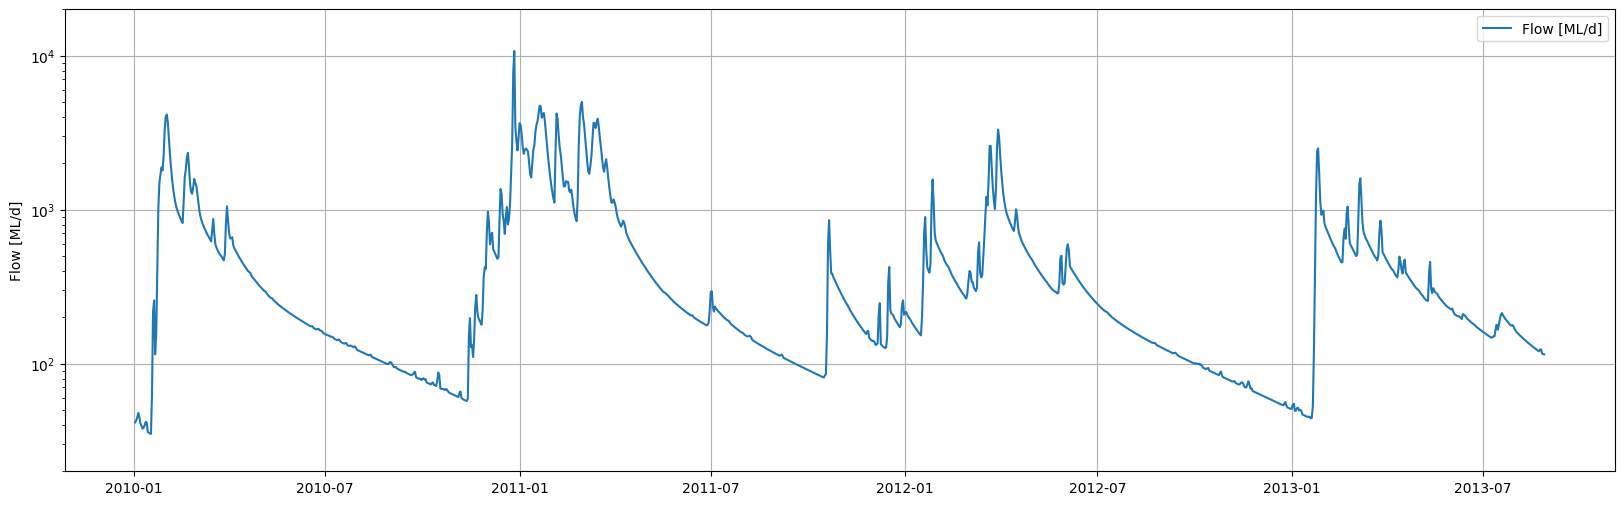

In [2]:
df = oio.read_ts_csv("./source_model_results/picnic_crossing_modelled_flow.csv")
df = out.convert_index_to_datetime(df)
df = df[df.index > "2010-01-01"]

a, b = opl.plot_flow(df)
b.set_ylim(20, 20000)

In [3]:
class routing_model():
    def __init__(self, x = 0, divs = 10, qq = [0, 1e2, 1e3, 1e4, 1e5], tt_total = [2, 2, 1.5, 1, 0.5]):
        # General properties
        self.quiet = True

        # Routing model properties
        self.x = x
        self.divs = divs
        self.tt_total = tt_total               #Travel time for the whole reach
        self.tt = [t / divs for t in tt_total] #Travel time per div
        self.qq = qq
        
        # Routing ABC table
        self.vv1, self.vv2, self.qq1, self.qq2, self.tt1, self.tt2,  = [], [], [], [], [], []
        self.aa, self.bb, self.cc = [], [], []
        self.nseg = len(self.tt) - 1
        v = 0
        for i in range(self.nseg):
            t1 = self.tt[i]
            t2 = self.tt[i + 1]
            q1 = self.qq[i]
            q2 = self.qq[i + 1]
            a = 0.5 * (t2 - t1) / (q2 - q1)
            b = t1 - q1 * (t2 - t1) / (q2 - q1)
            c = v - a*q1*q1 - b*q1
            v1 = v
            v2 = a*q2*q2 + b*q2 + c
            v = v2
            self.vv1.append(v1)
            self.vv2.append(v2)
            self.qq1.append(q1)
            self.qq2.append(q2)
            self.tt1.append(t1)
            self.tt2.append(t2)
            self.aa.append(a)
            self.bb.append(b)
            self.cc.append(c)        

        # State variables
        self.v = [0 for _ in range(self.divs)] #Initialize the inner volumes to zero
        self.qin = 0  #This means qin into the first division (for reporting)
        self.qout = 0 #This means qout from the last division (for reporting)

    def get_abc_table(self) -> pd.DataFrame:
        return pd.DataFrame({'v1': self.vv1, 'v2': self.vv2, 
                             'q1': self.qq1, 'q2': self.qq2, 
                             't1': self.tt1, 't2': self.tt2, 
                             'a': self.aa, 'b': self.bb, 'c': self.cc})

    def quadratic_xplus(self, a, b, c):
        d = b * b - 4 * a * c
        if d < 0:
            return None
        if a == 0:
            return (-c / b)
        xplus = (-b + d ** 0.5) / (2 * a)
        return xplus

    def solve_one_div(self, vi, qin):
        # for each segment calculate the solution
        # if the solution is within the segment, return it
        for i in range(self.nseg):
            a = self.aa[i]
            b = self.bb[i] + 1
            c = self.cc[i] - qin - vi
            qr = self.quadratic_xplus(a, b, c)
            if (qr >= self.qq[i] and qr <= self.qq[i + 1]):
                return qr

    def run(self, qin):
        # Record qin for reporting
        self.qin = qin 
        
        qout = np.nan
        for i in range(self.divs):
            vi = self.v[i]
            for j in range(self.nseg):
                
                if self.x > 0.999999:
                    # Calculate qr
                    qr = qin
                    
                    # Check if qin is within the segment
                    if (qin >= self.qq1[j]) and (qin <= self.qq2[j]):
                        
                        # Finalise solution
                        vf = self.aa[j] * qin * qin + self.bb[j] * qin + self.cc[j]
                        qout = vi + qin - vf
                        break

                else:
                    # Calculate qr
                    a = self.aa[j]
                    b = self.bb[j] + (1/(1 - self.x))
                    c = self.cc[j] - vi - qin/(1 - self.x)
                    qr = self.quadratic_xplus(a, b, c)

                    # Check if qr is within the segment
                    if (qr is not None and qr >= self.qq1[j] and qr <= self.qq2[j]):

                        # Finalise solution
                        qout = (qr - qin * self.x) / (1 - self.x)
                        vf = vi + qin - qout
                        break
            
            # end for j in range(self.nseg):
            
            # Dont allow water to flow upstream
            if qout < 0:
                qout = 0
                vf = vi + qin
                
            # Prepare for next division
            self.v[i] = vf
            qin = qout
            
        # end for i in range(self.divs):
        if np.isnan(qout):
            raise ArithmeticError(f"Algo1 -> qin {qin} not found")
            
        # Record qout for reporting and return it
        self.qout = qout
        return self.qout             


In [4]:
m = routing_model()
df_abc = m.get_abc_table()
df_abc

,v1,v2,q1,q2,t1,t2,a,b,c
0,0.0,20.0,0.0,100.0,0.20,0.20,0.000000e+00,0.200000,0.000000
1,20.0,177.5,100.0,1000.0,0.20,0.15,-2.777778e-05,0.205556,-0.277778
2,177.5,1302.5,1000.0,10000.0,0.15,0.10,-2.777778e-06,0.155556,24.722222
3,1302.5,8052.5,10000.0,100000.0,0.10,0.05,-2.777778e-07,0.105556,274.722222


In [5]:
m = routing_model()
us_flow = [200 for _ in range(20)]
ds_flow = [m.run(x) for x in us_flow]

In [6]:
m1 = routing_model(tt_total=[5, 2, 3, 1.5, 1, 0], qq=[0, 10, 100, 1000, 1e4, 1e5], x=0, divs=10)
m2 = routing_model(tt_total=[5, 2, 3, 1.5, 1, 0], qq=[0, 10, 100, 1000, 1e4, 1e5], x=0, divs=1)
m3 = routing_model(tt_total=[5, 2, 3, 1.5, 1, 0], qq=[0, 10, 100, 1000, 1e4, 1e5], x=1, divs=10)
m4 = routing_model(tt_total=[5, 2, 3, 1.5, 1, 0], qq=[0, 10, 100, 1000, 1e4, 1e5], x=0.5, divs=10)
m4.quiet = False

df["M1"] = [m1.run(x) for x in df["Flow [ML/d]"]]
df["M2"] = [m2.run(x) for x in df["Flow [ML/d]"]]
df["M3"] = [m3.run(x) for x in df["Flow [ML/d]"]]
df["M4"] = [m4.run(x) for x in df["Flow [ML/d]"]]
df

,Flow [ML/d],M1,M2,M3,M4
Date,,,,,
2010-01-02,41.537536,2.024518,8.905718,0.424787,1.117109
2010-01-03,42.702182,12.070222,19.928777,8.076277,10.324579
2010-01-04,44.779895,24.843476,27.807785,23.954652,24.463767
2010-01-05,47.817068,34.105298,33.998286,35.298949,34.572873
2010-01-06,45.271577,39.918319,37.429293,41.795215,40.727302
...,...,...,...,...,...
2013-08-24,122.901403,123.360911,124.250393,123.139715,123.244324
2013-08-25,123.799001,122.803016,124.136396,122.315497,122.569170
2013-08-26,116.332595,122.198119,122.166442,121.988041,122.133556


In [7]:
df.to_csv("./picnic_crossing_modelled_flow_routed.csv")

(20, 20000)

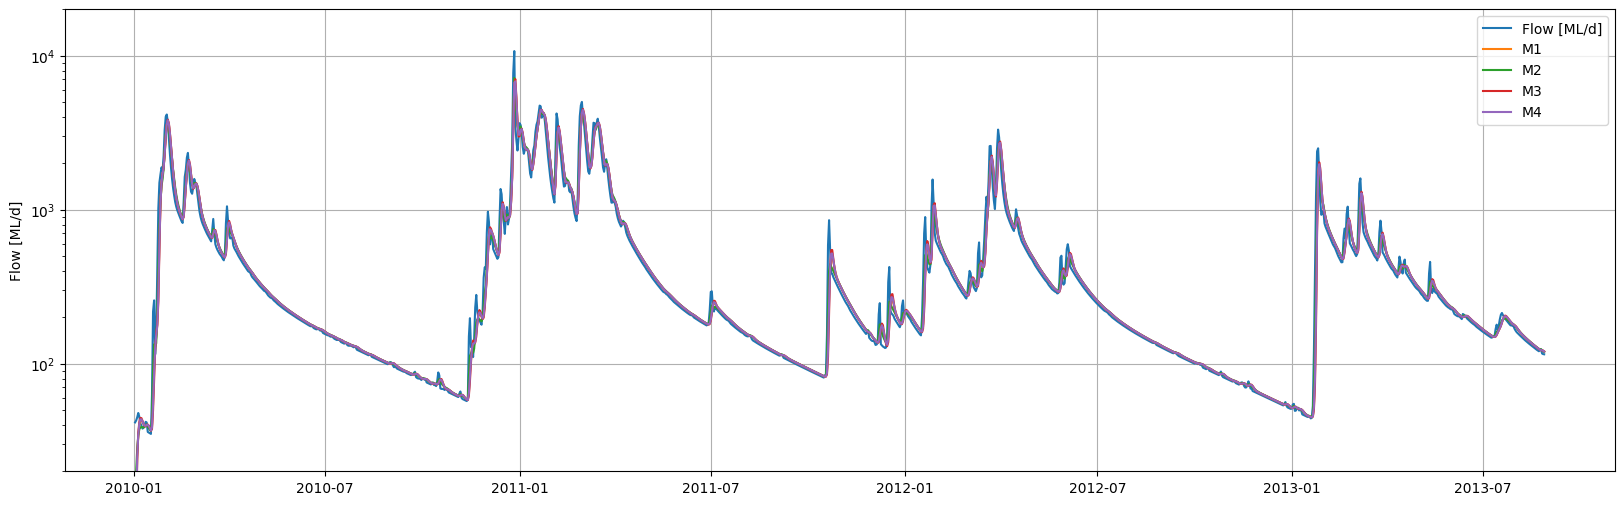

In [8]:
a, b = opl.plot_flow(df)
b.set_ylim(20, 20000)

(15737.0, 15857.0)

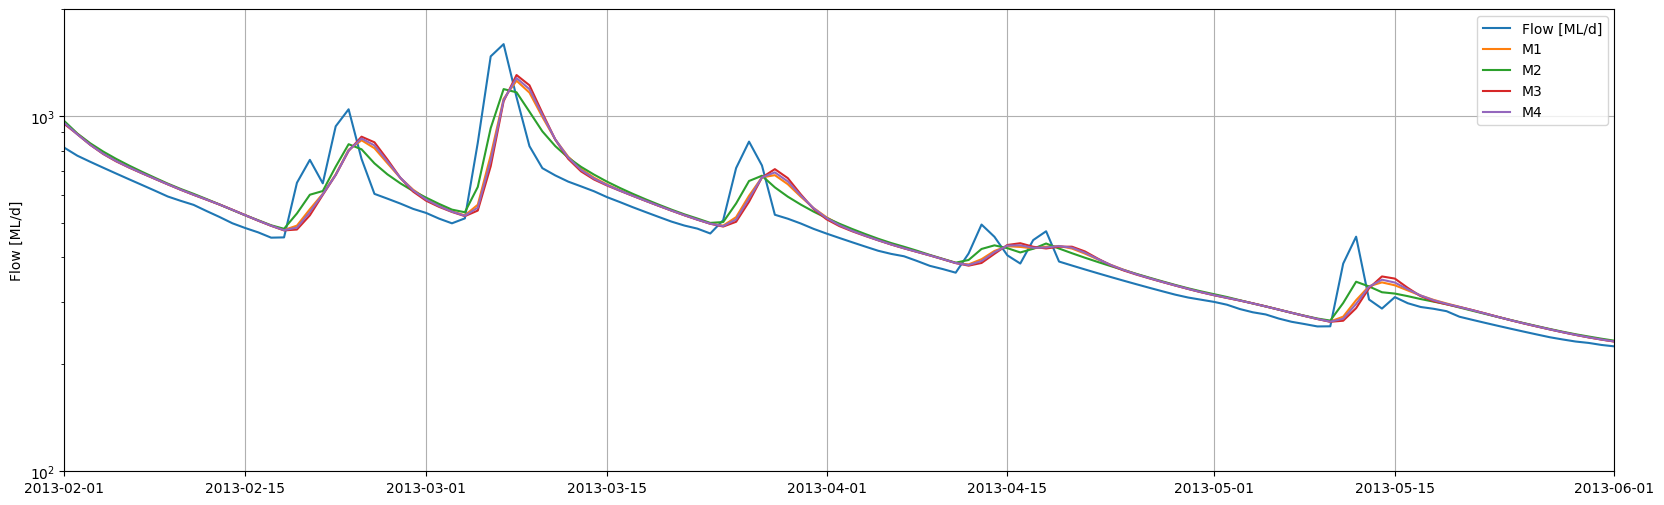

In [9]:
a, b = opl.plot_flow(df)
b.set_ylim(100, 2000)
b.set_xlim(datetime(2013, 2, 1), datetime(2013, 6, 1))

In [10]:
df_source_answers = oio.read_res_csv("./source_model_results/source_model_results.res.csv")
df_source_answers.sum()

1>Outflow1>Downstream Flow    686488.747799
2>Outflow1>Storage Volume          0.000000
3>Outflow2>Downstream Flow    686483.546161
4>Outflow2>Storage Volume          0.000000
5>Outflow3>Downstream Flow    686490.071869
6>Outflow3>Storage Volume          0.000000
7>Outflow4>Downstream Flow    686489.383418
8>Outflow4>Storage Volume          0.000000
9>Inflow1>Downstream Flow     686800.447334
10>Inflow2>Downstream Flow    686800.447334
11>Inflow3>Downstream Flow    686800.447334
12>Inflow4>Downstream Flow    686800.447334
dtype: float64

In [11]:
def sum_abs_error(s1, s2):
    n = min(len(s1), len(s2))
    ans = 0
    for i in range(n):
        err = s1.iloc[i] - s2.iloc[i]
        ans += abs(err)
    print(f"Error over {n} points: {ans}")
    #return ans
        
        

In [12]:
print("Comparing unrouted and routed flow:")
sum_abs_error(df_source_answers["9>Inflow1>Downstream Flow"], df_source_answers["1>Outflow1>Downstream Flow"])

print()
print("Comparing Source and Kalix routed flow:")
sum_abs_error(df_source_answers["1>Outflow1>Downstream Flow"], df["M1"])
sum_abs_error(df_source_answers["3>Outflow2>Downstream Flow"], df["M2"])
sum_abs_error(df_source_answers["5>Outflow3>Downstream Flow"], df["M3"])
sum_abs_error(df_source_answers["7>Outflow4>Downstream Flow"], df["M4"])

Comparing unrouted and routed flow:
Error over 1335 points: 116285.56159715765

Comparing Source and Kalix routed flow:
Error over 1335 points: 0.00015893344005046828
Error over 1335 points: 0.00019427508000013916
Error over 1335 points: 1.6021367565954847e-10
Error over 1335 points: 0.00011701182902323914
